# Aqueous speciation in the system Cu-Co-S-Cl-Na
In this notebook, I determine the speciation of Cu and Co in a saline, S-bearing aqueous solution under hydrothermal conditions. 

## 1. Import Libraries

In [1]:
import thermofun as fun
import reaktoro as rkt
import numpy as np
import matplotlib.pyplot as plt
import random

## 2. Initialize a thermodynamic database

In [2]:
database = fun.Database('./databases/Willy_ThermoFun_db.json')
#database = fun.Database('./databases/ThermoFun_db/mines16-thermofun.json')
#database.appendData('./databases/ThermoFun_db/mines16-thermofun.json')
database.appendData('./databases/elements.json') # append element data & data for H2O(l), OH-, and H+ to database
database.appendData('./databases/Willy_ThermoFun_db.json') # append data for Cu and Co species with correct units
database.appendData('./databases/Co_complexes.json') # append data for Co complexes
database.appendData('./databases/fO2_buffers.json') 

### 2a. Check the contents of the database (optional)

In [3]:
substances = database.mapSubstances()
# print(substances.keys())

## 3. Define and construct the chemical system

### 3a. Define and construct the main system

In [4]:
# Define the chemical system
editor = rkt.ChemicalEditor(database)
aqueousphase = editor.addAqueousPhaseWithElements([
    'H', 'O', 'Cl', 'Na', 'S', 'Co', 'Cu'])
aqueousphase.setChemicalModelDebyeHuckel()
editor.addGaseousPhase([
    'O2,rg', 'H2O,rg'
])
# Construct the chemical system
system = rkt.ChemicalSystem(editor)

### 3b. Partition the main chemical system so as to fix $fO_2$ according to the $fO_2$ buffer reaction

In [5]:
partition = rkt.Partition(system)
partition.setInertSpecies(['O2,rg'])

### 3c. Define the $fO_2$ buffer reaction
$$2NiO_{(s)} \leftrightarrow 2Ni_{(s)} + O_{2(g)}$$
$$K = fO_2$$
$$logK = logfO_2$$
$$fO_2 = 10^{logK}$$

In [6]:
# initialize ThermoFun engine for calculation of fO2 buffer reaction properties
engine = fun.ThermoEngine(database)
# define fO2 buffer reaction
fO2_buffer_rxn = "2Bsn = 2Nickel + O2,rg"

## 4. Set temperature and pressure conditions

In [7]:
temperature = np.linspace(150,325,num=100) + 273.15 # [K]

# set water saturated vapor pressure
pressure = np.zeros(len(temperature))
for i,T in enumerate(temperature):
    pressure[i] = rkt.waterSaturatedPressureWagnerPruss(T).val/100000 # [bar] 

## 5. Set pH and chlorinity conditions

In [8]:
pH = 2
# chlorinity
Cl_amounts = 1 # [mol*kg^-1]

## 6. Define the equilibrium problem

In [9]:
problems = []
for T,P in zip(temperature,pressure): 
    # define main equilibrium problem
    problem = rkt.EquilibriumProblem(system)
    problem.add("CuCo2S4",1,"g")
    problem.add("H2O",1,"kg")
    problem.add("HCl",10**-pH,"mol")
    problem.add("NaCl",Cl_amounts - 10**-pH,"mol")
    
    # get logK for fO2 buffer rxn
    rxn_properties = engine.thermoPropertiesReaction(T, P, fO2_buffer_rxn)
    logK = rxn_properties.log_equilibrium_constant
    amount_O2 = 10**logK.val
    # add O2 to system w/ value corresponding to buffer rxn
    problem.add("O2",10**logK.val,"mol")
    
    problem.setTemperature(T,"kelvin")
    problem.setPressure(P,"bar")
    
    problems.append(problem) # append the new problem onto problems

## 7. Solve equilibrium states

### 7a. Set some model parameters

In [10]:
# set minimum value for equilibrium calculation
options = rkt.EquilibriumOptions()
options.optimum.output.active = True
options.epsilon = 1e-20

### 7b. Solve!

In [11]:
solver = rkt.EquilibriumSolver(system)
states = [rkt.ChemicalState(system) for _ in range(len(problems))]
solver.setOptions(options)
for i in range(len(problems)): 
    solver.solve(states[i], problems[i])

## 8. Get species with elements of interest

### 8a. Define a function to get species

In [12]:
def get_species_w_elements(elements): 
    matrix = system.formulaMatrix()
    species_names = []
    for j in range(len(elements)):
        species_names_list = []
        for i in range(len(matrix[system.indexElement(elements[j])])): 
            if matrix[system.indexElement(elements[j])][i] == 1:
                species_names_list.append(system.species(i).name())
        species_names.append(species_names_list)
    return species_names

### 8b. Get species

In [13]:
species_names = get_species_w_elements(["Cu", "Co"])
print(species_names)

[['Cu(HS)2-', 'Cu(OH)2-', 'Cu+', 'Cu++', 'CuCl', 'CuCl+', 'CuCl2', 'CuCl2-', 'CuCl3-', 'CuCl3--', 'CuCl4--', 'CuHS', 'CuO', 'CuO2--', 'CuOH', 'CuOH+', 'HCuO2-'], ['Co++', 'Co+++', 'CoCl+', 'CoCl2@', 'CoCl3-', 'CoCl4--', 'CoCl4-2', 'CoH2S+2', 'CoHS+', 'CoO', 'CoO2--', 'CoOH+', 'CoOH++', 'HCoO2-']]


## 9. Get equilibrium amounts of above species 

### 9a. Define a function to get amounts of species

In [14]:
def get_species_amounts(species_names): 
    species_amounts = []
    for j in range(len(species_names)):
        species_amount = []
        for i in range(len(species_names[j])): 
            species_amount.append([state.speciesAmount(species_names[j][i]) for state in states])
        species_amounts.append(species_amount)
    return species_amounts

### 9b. Get species amounts

In [15]:
species_amounts = get_species_amounts(species_names)
# print(species_amounts)

[[[2.8390325696673557e-22, 2.863682107286468e-22, 2.8885463364008114e-22, 2.913628202038086e-22, 2.9389306915380474e-22, 2.964456835198155e-22, 2.9902097069698223e-22, 3.0161924252171282e-22, 3.042408153533087e-22, 3.0688601016175054e-22, 3.095551526214641e-22, 3.1224857321095455e-22, 3.1496660731820575e-22, 3.1770959535157544e-22, 3.2047788285595275e-22, 3.232314862542019e-22, 3.260033722595512e-22, 3.2880053034201447e-22, 3.316233080564451e-22, 3.3447205737474665e-22, 3.3734713483148766e-22, 3.402489016748289e-22, 3.4317772402181763e-22, 3.4613397301726656e-22, 3.491180249960023e-22, 3.5213026164781446e-22, 3.55171070184877e-22, 3.5824084351100717e-22, 3.6133998039313034e-22, 3.6444315169676006e-22, 3.675656491656361e-22, 3.7071807193246206e-22, 3.7390082211769786e-22, 3.771143071891786e-22, 3.8035894016383193e-22, 3.8363513980541686e-22, 3.869433308191682e-22, 3.9028394404281764e-22, 3.936574166341542e-22, 3.970641922560861e-22, 4.0050472125832694e-22, 4.0397946085699244e-22, 4.0748

## 9. Plot the results

### 9a. Define function for plotting a custom figure

In [16]:
def custom_figure(x, y, fig, ax, legend_items=None, 
                  y_label=None, title=None, colors=None, plot_kwargs={}, legend_kwargs={}): 
    
    # set figure size
    fig.set_figheight(8)
    fig.set_figwidth(12)
    
    # set curve colors
    ax.set_prop_cycle('color', colors)
    
    # set background color
    ax.set_facecolor('w')
    
    # plot each curve
    ax.plot(x, np.transpose(y), **plot_kwargs)
    
    # define and place the legend
    ax.legend(legend_items, bbox_to_anchor=(1.04,1), loc="upper left", prop={"size":15}, **legend_kwargs)
    
    # set axes labels and title
    ax.set_xlabel('temperature (°C)')  
    ax.set_ylabel(y_label)  
    ax.set_title(title)   

### 9b. Plot Cu species

In [17]:
# set colors copied from [Colorgorical](http://vrl.cs.brown.edu/color)
colors0 = ["#a0e3b7", "#1c5872", "#37d356", "#860967", "#1aa7ee", "#473c85", 
            "#8fba06", "#6314af", "#fd92fa", "#1d6d1f", "#f7393a", "#fbd127", 
            "#873c1a", "#ffb4a2", "#464a15", "#d6bcf5", "#627de3"]
# shuffle color order
random.shuffle(colors0)

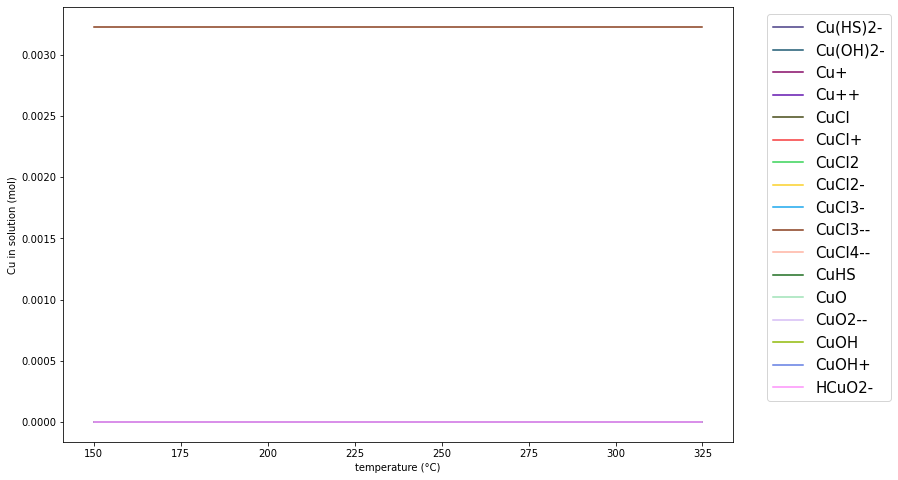

In [19]:
# set figure and axes
fig0, ax0 = plt.subplots()

# plot data
custom_figure(temperature-273.15, species_amounts[0], fig0, ax0, 
              legend_items=species_names[0],
              colors=colors0,
              y_label='Cu in solution (mol)')


### 9c. Plot Co species

In [20]:
# set colors copied from [Colorgorical](http://vrl.cs.brown.edu/color)
colors1 = ["#41bbc5", "#422fae", "#a5d65a", "#b12060", "#42f18f", "#275b52", "#d5d2e7", 
           "#2c457d", "#faafe3", "#658114", "#fb5de7", "#51f310", "#d11f0b"]
# shuffle color order
random.shuffle(colors1)

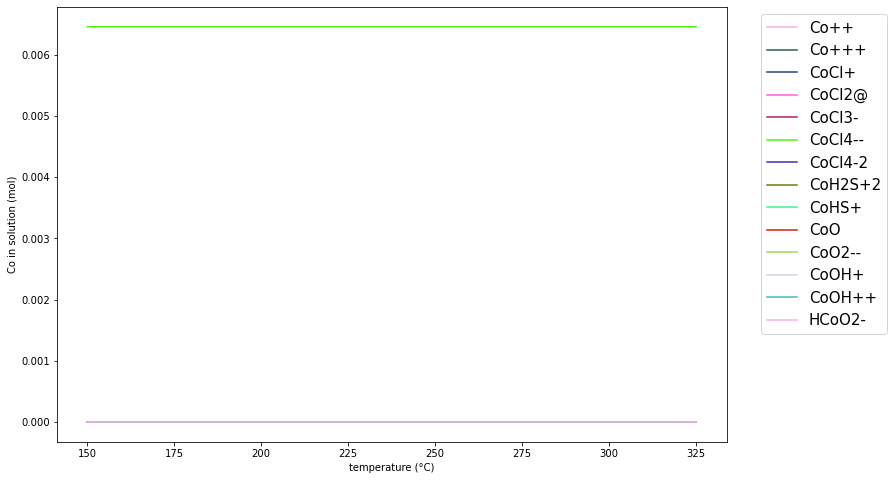

In [22]:
# set figure and axes
fig1, ax1 = plt.subplots()

# plot data
custom_figure(temperature-273.15, species_amounts[1], fig1, ax1, 
              legend_items=species_names[1],
              colors=colors1,
              y_label='Co in solution (mol)')


## 10. Retrieve and plot ionic strength

In [23]:
def get_ionic_strength(): 
    ionic_strength = np.zeros(len(temperature))
    for i,state in enumerate(states):
        properties = state.properties()
        ionic_strength_function = rkt.ChemicalProperty.ionicStrength(system)
        ionic_strength[i] = ionic_strength_function(properties).val
    return ionic_strength

In [24]:
ionic_strength = get_ionic_strength()

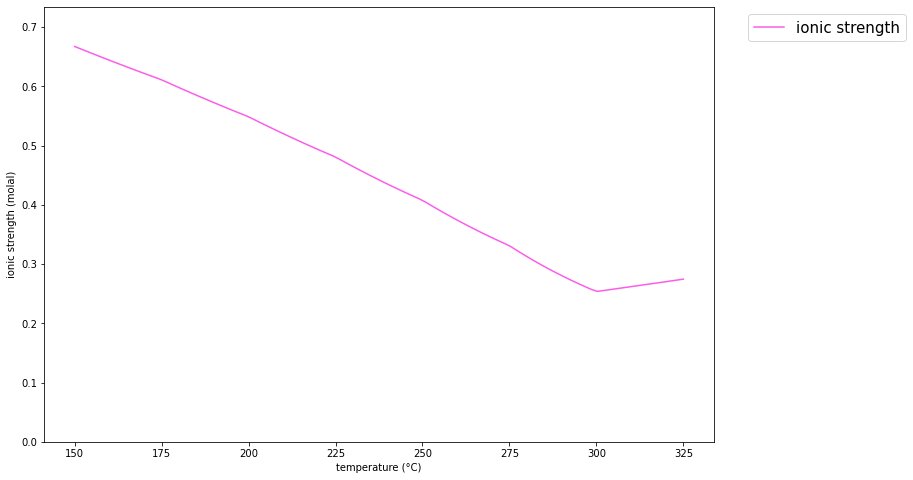

In [26]:
# set figure and axes
fig2, ax2 = plt.subplots()
ax2.set_ylim([0,1.1*max(ionic_strength)])
# plot data
custom_figure(temperature-273.15, ionic_strength, fig2, ax2, 
              legend_items=["ionic strength"],
              colors=colors1[3],
              y_label='ionic strength (molal)')